In [2]:
import numpy as np 
import os
import matplotlib.pyplot as plt
import librosa, librosa.display
import math
import json
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Input, Flatten, Dense, Conv2D, BatchNormalization, LeakyReLU, Dropout, Activation, MaxPooling2D
from keras.models import Model
from keras.optimizers import Adam

Using TensorFlow backend.
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

## PREPROCESSING AUDIO BASICS

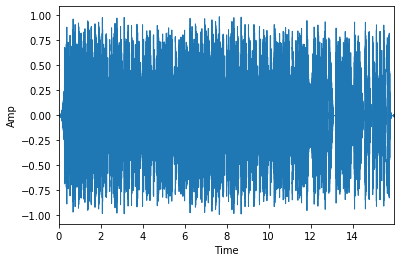

In [3]:
file = 'BR.wav'

sig, sr = librosa.load(file, sr=22050)
librosa.display.waveplot(sig, sr = sr)
plt.xlabel("Time")
plt.ylabel("Amp")
plt.show()

Text(0, 0.5, 'Mag')

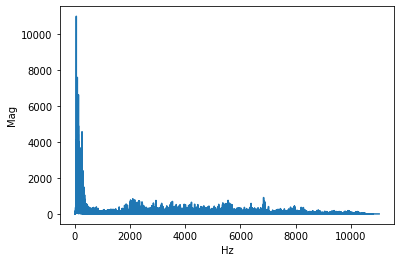

In [4]:
fft = np.fft.fft(sig)
mag = np.abs(fft)
freq = np.linspace(0, sr, len(mag))
hfreq = freq[:int(len(freq)/2)]
hmag = mag[:int(len(mag)/2)]
plt.plot(hfreq,hmag)
plt.xlabel("Hz")
plt.ylabel("Mag")

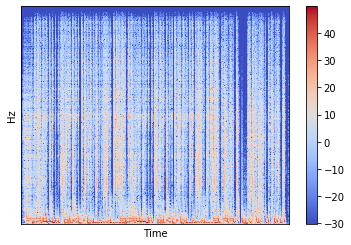

In [5]:
n_fft = 2048
hop_size = 512

stft = librosa.core.stft(sig, hop_length = hop_size, n_fft = n_fft)
spec = np.abs(stft)
log_spec = librosa.amplitude_to_db(spec)
librosa.display.specshow(log_spec,sr = sr, hop_length = hop_size)
plt.xlabel("Time")
plt.ylabel("Hz")
plt.colorbar()
plt.show()

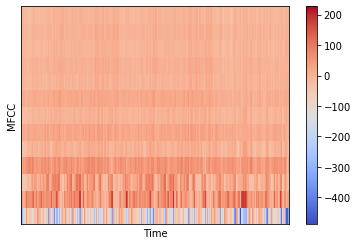

In [6]:
MFCCs = librosa.feature.mfcc(sig, n_fft = 2048, hop_length = hop_size, n_mfcc = 13)
librosa.display.specshow(MFCCs,sr = sr, hop_length = hop_size)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show()



## PREPROCESSING MUSIC GENRE DATASET

In [7]:
DATASET_P = "genres" # using the genre dataset from http://marsyas.info/downloads/datasets.html
JSON_P = "data.json"
SAMPLE_RATE = 22050
DURATION = 30 # seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048, hop_length=512, n_segments=5):
    data = {
        "mapping": [],
        "mfcc"   : [],
        "label"  : []
    }
    
    num_samples_per_segment = int (SAMPLES_PER_TRACK / n_segments)
    expected_num_mfcc_vecs_per_segment = math.ceil(num_samples_per_segment / hop_length)
    
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath is not dataset_path:
            dirpath_components = dirpath.split("/")
            semantic_label = dirpath_components[-1]
            data["mapping"].append(semantic_label)
            print("\n Processing {}".format(semantic_label))
            
            for f in filenames:
                file_path = os.path.join(dirpath, f) 
                sig, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                # process segment, extract mfcc, store data
                
                for s in range(n_segments):
                    start_s = num_samples_per_segment * s
                    end_s   = start_s + num_samples_per_segment
                    mfcc = librosa.feature.mfcc(sig[start_s:end_s], sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
                    mfcc = mfcc.T
                    if len(mfcc) == expected_num_mfcc_vecs_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["label"].append(i-1) # first iteration is the dataset path, so we ignore it
                        print("{}, segment:{}".format(file_path,s+1))
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
        

In [8]:
save_mfcc(DATASET_P, JSON_P, n_segments=10)


 Processing pop
genres/pop/pop.00027.wav, segment:1
genres/pop/pop.00027.wav, segment:2
genres/pop/pop.00027.wav, segment:3
genres/pop/pop.00027.wav, segment:4
genres/pop/pop.00027.wav, segment:5
genres/pop/pop.00027.wav, segment:6
genres/pop/pop.00027.wav, segment:7
genres/pop/pop.00027.wav, segment:8
genres/pop/pop.00027.wav, segment:9
genres/pop/pop.00027.wav, segment:10
genres/pop/pop.00033.wav, segment:1
genres/pop/pop.00033.wav, segment:2
genres/pop/pop.00033.wav, segment:3
genres/pop/pop.00033.wav, segment:4
genres/pop/pop.00033.wav, segment:5
genres/pop/pop.00033.wav, segment:6
genres/pop/pop.00033.wav, segment:7
genres/pop/pop.00033.wav, segment:8
genres/pop/pop.00033.wav, segment:9
genres/pop/pop.00033.wav, segment:10
genres/pop/pop.00032.wav, segment:1
genres/pop/pop.00032.wav, segment:2
genres/pop/pop.00032.wav, segment:3
genres/pop/pop.00032.wav, segment:4
genres/pop/pop.00032.wav, segment:5
genres/pop/pop.00032.wav, segment:6
genres/pop/pop.00032.wav, segment:7
genres/po

genres/pop/pop.00093.wav, segment:3
genres/pop/pop.00093.wav, segment:4
genres/pop/pop.00093.wav, segment:5
genres/pop/pop.00093.wav, segment:6
genres/pop/pop.00093.wav, segment:7
genres/pop/pop.00093.wav, segment:8
genres/pop/pop.00093.wav, segment:9
genres/pop/pop.00093.wav, segment:10
genres/pop/pop.00092.wav, segment:1
genres/pop/pop.00092.wav, segment:2
genres/pop/pop.00092.wav, segment:3
genres/pop/pop.00092.wav, segment:4
genres/pop/pop.00092.wav, segment:5
genres/pop/pop.00092.wav, segment:6
genres/pop/pop.00092.wav, segment:7
genres/pop/pop.00092.wav, segment:8
genres/pop/pop.00092.wav, segment:9
genres/pop/pop.00092.wav, segment:10
genres/pop/pop.00086.wav, segment:1
genres/pop/pop.00086.wav, segment:2
genres/pop/pop.00086.wav, segment:3
genres/pop/pop.00086.wav, segment:4
genres/pop/pop.00086.wav, segment:5
genres/pop/pop.00086.wav, segment:6
genres/pop/pop.00086.wav, segment:7
genres/pop/pop.00086.wav, segment:8
genres/pop/pop.00086.wav, segment:9
genres/pop/pop.00086.wav, 

genres/pop/pop.00041.wav, segment:9
genres/pop/pop.00041.wav, segment:10
genres/pop/pop.00055.wav, segment:1
genres/pop/pop.00055.wav, segment:2
genres/pop/pop.00055.wav, segment:3
genres/pop/pop.00055.wav, segment:4
genres/pop/pop.00055.wav, segment:5
genres/pop/pop.00055.wav, segment:6
genres/pop/pop.00055.wav, segment:7
genres/pop/pop.00055.wav, segment:8
genres/pop/pop.00055.wav, segment:9
genres/pop/pop.00055.wav, segment:10
genres/pop/pop.00082.wav, segment:1
genres/pop/pop.00082.wav, segment:2
genres/pop/pop.00082.wav, segment:3
genres/pop/pop.00082.wav, segment:4
genres/pop/pop.00082.wav, segment:5
genres/pop/pop.00082.wav, segment:6
genres/pop/pop.00082.wav, segment:7
genres/pop/pop.00082.wav, segment:8
genres/pop/pop.00082.wav, segment:9
genres/pop/pop.00082.wav, segment:10
genres/pop/pop.00096.wav, segment:1
genres/pop/pop.00096.wav, segment:2
genres/pop/pop.00096.wav, segment:3
genres/pop/pop.00096.wav, segment:4
genres/pop/pop.00096.wav, segment:5
genres/pop/pop.00096.wav,

genres/pop/pop.00062.wav, segment:4
genres/pop/pop.00062.wav, segment:5
genres/pop/pop.00062.wav, segment:6
genres/pop/pop.00062.wav, segment:7
genres/pop/pop.00062.wav, segment:8
genres/pop/pop.00062.wav, segment:9
genres/pop/pop.00062.wav, segment:10
genres/pop/pop.00076.wav, segment:1
genres/pop/pop.00076.wav, segment:2
genres/pop/pop.00076.wav, segment:3
genres/pop/pop.00076.wav, segment:4
genres/pop/pop.00076.wav, segment:5
genres/pop/pop.00076.wav, segment:6
genres/pop/pop.00076.wav, segment:7
genres/pop/pop.00076.wav, segment:8
genres/pop/pop.00076.wav, segment:9
genres/pop/pop.00076.wav, segment:10
genres/pop/pop.00048.wav, segment:1
genres/pop/pop.00048.wav, segment:2
genres/pop/pop.00048.wav, segment:3
genres/pop/pop.00048.wav, segment:4
genres/pop/pop.00048.wav, segment:5
genres/pop/pop.00048.wav, segment:6
genres/pop/pop.00048.wav, segment:7
genres/pop/pop.00048.wav, segment:8
genres/pop/pop.00048.wav, segment:9
genres/pop/pop.00048.wav, segment:10
genres/pop/pop.00060.wav,

genres/pop/pop.00003.wav, segment:10
genres/pop/pop.00017.wav, segment:1
genres/pop/pop.00017.wav, segment:2
genres/pop/pop.00017.wav, segment:3
genres/pop/pop.00017.wav, segment:4
genres/pop/pop.00017.wav, segment:5
genres/pop/pop.00017.wav, segment:6
genres/pop/pop.00017.wav, segment:7
genres/pop/pop.00017.wav, segment:8
genres/pop/pop.00017.wav, segment:9
genres/pop/pop.00017.wav, segment:10
genres/pop/pop.00016.wav, segment:1
genres/pop/pop.00016.wav, segment:2
genres/pop/pop.00016.wav, segment:3
genres/pop/pop.00016.wav, segment:4
genres/pop/pop.00016.wav, segment:5
genres/pop/pop.00016.wav, segment:6
genres/pop/pop.00016.wav, segment:7
genres/pop/pop.00016.wav, segment:8
genres/pop/pop.00016.wav, segment:9
genres/pop/pop.00016.wav, segment:10
genres/pop/pop.00002.wav, segment:1
genres/pop/pop.00002.wav, segment:2
genres/pop/pop.00002.wav, segment:3
genres/pop/pop.00002.wav, segment:4
genres/pop/pop.00002.wav, segment:5
genres/pop/pop.00002.wav, segment:6
genres/pop/pop.00002.wav,

genres/metal/metal.00082.wav, segment:4
genres/metal/metal.00082.wav, segment:5
genres/metal/metal.00082.wav, segment:6
genres/metal/metal.00082.wav, segment:7
genres/metal/metal.00082.wav, segment:8
genres/metal/metal.00082.wav, segment:9
genres/metal/metal.00082.wav, segment:10
genres/metal/metal.00096.wav, segment:1
genres/metal/metal.00096.wav, segment:2
genres/metal/metal.00096.wav, segment:3
genres/metal/metal.00096.wav, segment:4
genres/metal/metal.00096.wav, segment:5
genres/metal/metal.00096.wav, segment:6
genres/metal/metal.00096.wav, segment:7
genres/metal/metal.00096.wav, segment:8
genres/metal/metal.00096.wav, segment:9
genres/metal/metal.00096.wav, segment:10
genres/metal/metal.00069.wav, segment:1
genres/metal/metal.00069.wav, segment:2
genres/metal/metal.00069.wav, segment:3
genres/metal/metal.00069.wav, segment:4
genres/metal/metal.00069.wav, segment:5
genres/metal/metal.00069.wav, segment:6
genres/metal/metal.00069.wav, segment:7
genres/metal/metal.00069.wav, segment:

genres/metal/metal.00047.wav, segment:8
genres/metal/metal.00047.wav, segment:9
genres/metal/metal.00047.wav, segment:10
genres/metal/metal.00046.wav, segment:1
genres/metal/metal.00046.wav, segment:2
genres/metal/metal.00046.wav, segment:3
genres/metal/metal.00046.wav, segment:4
genres/metal/metal.00046.wav, segment:5
genres/metal/metal.00046.wav, segment:6
genres/metal/metal.00046.wav, segment:7
genres/metal/metal.00046.wav, segment:8
genres/metal/metal.00046.wav, segment:9
genres/metal/metal.00046.wav, segment:10
genres/metal/metal.00052.wav, segment:1
genres/metal/metal.00052.wav, segment:2
genres/metal/metal.00052.wav, segment:3
genres/metal/metal.00052.wav, segment:4
genres/metal/metal.00052.wav, segment:5
genres/metal/metal.00052.wav, segment:6
genres/metal/metal.00052.wav, segment:7
genres/metal/metal.00052.wav, segment:8
genres/metal/metal.00052.wav, segment:9
genres/metal/metal.00052.wav, segment:10
genres/metal/metal.00085.wav, segment:1
genres/metal/metal.00085.wav, segment

genres/metal/metal.00076.wav, segment:1
genres/metal/metal.00076.wav, segment:2
genres/metal/metal.00076.wav, segment:3
genres/metal/metal.00076.wav, segment:4
genres/metal/metal.00076.wav, segment:5
genres/metal/metal.00076.wav, segment:6
genres/metal/metal.00076.wav, segment:7
genres/metal/metal.00076.wav, segment:8
genres/metal/metal.00076.wav, segment:9
genres/metal/metal.00076.wav, segment:10
genres/metal/metal.00089.wav, segment:1
genres/metal/metal.00089.wav, segment:2
genres/metal/metal.00089.wav, segment:3
genres/metal/metal.00089.wav, segment:4
genres/metal/metal.00089.wav, segment:5
genres/metal/metal.00089.wav, segment:6
genres/metal/metal.00089.wav, segment:7
genres/metal/metal.00089.wav, segment:8
genres/metal/metal.00089.wav, segment:9
genres/metal/metal.00089.wav, segment:10
genres/metal/metal.00099.wav, segment:1
genres/metal/metal.00099.wav, segment:2
genres/metal/metal.00099.wav, segment:3
genres/metal/metal.00099.wav, segment:4
genres/metal/metal.00099.wav, segment:

genres/metal/metal.00015.wav, segment:9
genres/metal/metal.00015.wav, segment:10
genres/metal/metal.00029.wav, segment:1
genres/metal/metal.00029.wav, segment:2
genres/metal/metal.00029.wav, segment:3
genres/metal/metal.00029.wav, segment:4
genres/metal/metal.00029.wav, segment:5
genres/metal/metal.00029.wav, segment:6
genres/metal/metal.00029.wav, segment:7
genres/metal/metal.00029.wav, segment:8
genres/metal/metal.00029.wav, segment:9
genres/metal/metal.00029.wav, segment:10
genres/metal/metal.00011.wav, segment:1
genres/metal/metal.00011.wav, segment:2
genres/metal/metal.00011.wav, segment:3
genres/metal/metal.00011.wav, segment:4
genres/metal/metal.00011.wav, segment:5
genres/metal/metal.00011.wav, segment:6
genres/metal/metal.00011.wav, segment:7
genres/metal/metal.00011.wav, segment:8
genres/metal/metal.00011.wav, segment:9
genres/metal/metal.00011.wav, segment:10
genres/metal/metal.00005.wav, segment:1
genres/metal/metal.00005.wav, segment:2
genres/metal/metal.00005.wav, segment

genres/disco/disco.00051.wav, segment:4
genres/disco/disco.00051.wav, segment:5
genres/disco/disco.00051.wav, segment:6
genres/disco/disco.00051.wav, segment:7
genres/disco/disco.00051.wav, segment:8
genres/disco/disco.00051.wav, segment:9
genres/disco/disco.00051.wav, segment:10
genres/disco/disco.00079.wav, segment:1
genres/disco/disco.00079.wav, segment:2
genres/disco/disco.00079.wav, segment:3
genres/disco/disco.00079.wav, segment:4
genres/disco/disco.00079.wav, segment:5
genres/disco/disco.00079.wav, segment:6
genres/disco/disco.00079.wav, segment:7
genres/disco/disco.00079.wav, segment:8
genres/disco/disco.00079.wav, segment:9
genres/disco/disco.00079.wav, segment:10
genres/disco/disco.00086.wav, segment:1
genres/disco/disco.00086.wav, segment:2
genres/disco/disco.00086.wav, segment:3
genres/disco/disco.00086.wav, segment:4
genres/disco/disco.00086.wav, segment:5
genres/disco/disco.00086.wav, segment:6
genres/disco/disco.00086.wav, segment:7
genres/disco/disco.00086.wav, segment:

genres/disco/disco.00095.wav, segment:1
genres/disco/disco.00095.wav, segment:2
genres/disco/disco.00095.wav, segment:3
genres/disco/disco.00095.wav, segment:4
genres/disco/disco.00095.wav, segment:5
genres/disco/disco.00095.wav, segment:6
genres/disco/disco.00095.wav, segment:7
genres/disco/disco.00095.wav, segment:8
genres/disco/disco.00095.wav, segment:9
genres/disco/disco.00095.wav, segment:10
genres/disco/disco.00042.wav, segment:1
genres/disco/disco.00042.wav, segment:2
genres/disco/disco.00042.wav, segment:3
genres/disco/disco.00042.wav, segment:4
genres/disco/disco.00042.wav, segment:5
genres/disco/disco.00042.wav, segment:6
genres/disco/disco.00042.wav, segment:7
genres/disco/disco.00042.wav, segment:8
genres/disco/disco.00042.wav, segment:9
genres/disco/disco.00042.wav, segment:10
genres/disco/disco.00056.wav, segment:1
genres/disco/disco.00056.wav, segment:2
genres/disco/disco.00056.wav, segment:3
genres/disco/disco.00056.wav, segment:4
genres/disco/disco.00056.wav, segment:

genres/disco/disco.00009.wav, segment:8
genres/disco/disco.00009.wav, segment:9
genres/disco/disco.00009.wav, segment:10
genres/disco/disco.00010.wav, segment:1
genres/disco/disco.00010.wav, segment:2
genres/disco/disco.00010.wav, segment:3
genres/disco/disco.00010.wav, segment:4
genres/disco/disco.00010.wav, segment:5
genres/disco/disco.00010.wav, segment:6
genres/disco/disco.00010.wav, segment:7
genres/disco/disco.00010.wav, segment:8
genres/disco/disco.00010.wav, segment:9
genres/disco/disco.00010.wav, segment:10
genres/disco/disco.00004.wav, segment:1
genres/disco/disco.00004.wav, segment:2
genres/disco/disco.00004.wav, segment:3
genres/disco/disco.00004.wav, segment:4
genres/disco/disco.00004.wav, segment:5
genres/disco/disco.00004.wav, segment:6
genres/disco/disco.00004.wav, segment:7
genres/disco/disco.00004.wav, segment:8
genres/disco/disco.00004.wav, segment:9
genres/disco/disco.00004.wav, segment:10
genres/disco/disco.00038.wav, segment:1
genres/disco/disco.00038.wav, segment

genres/disco/disco.00067.wav, segment:7
genres/disco/disco.00067.wav, segment:8
genres/disco/disco.00067.wav, segment:9
genres/disco/disco.00067.wav, segment:10
genres/disco/disco.00098.wav, segment:1
genres/disco/disco.00098.wav, segment:2
genres/disco/disco.00098.wav, segment:3
genres/disco/disco.00098.wav, segment:4
genres/disco/disco.00098.wav, segment:5
genres/disco/disco.00098.wav, segment:6
genres/disco/disco.00098.wav, segment:7
genres/disco/disco.00098.wav, segment:8
genres/disco/disco.00098.wav, segment:9
genres/disco/disco.00098.wav, segment:10
genres/disco/disco.00099.wav, segment:1
genres/disco/disco.00099.wav, segment:2
genres/disco/disco.00099.wav, segment:3
genres/disco/disco.00099.wav, segment:4
genres/disco/disco.00099.wav, segment:5
genres/disco/disco.00099.wav, segment:6
genres/disco/disco.00099.wav, segment:7
genres/disco/disco.00099.wav, segment:8
genres/disco/disco.00099.wav, segment:9
genres/disco/disco.00099.wav, segment:10
genres/disco/disco.00066.wav, segment

genres/disco/disco.00063.wav, segment:5
genres/disco/disco.00063.wav, segment:6
genres/disco/disco.00063.wav, segment:7
genres/disco/disco.00063.wav, segment:8
genres/disco/disco.00063.wav, segment:9
genres/disco/disco.00063.wav, segment:10
genres/disco/disco.00077.wav, segment:1
genres/disco/disco.00077.wav, segment:2
genres/disco/disco.00077.wav, segment:3
genres/disco/disco.00077.wav, segment:4
genres/disco/disco.00077.wav, segment:5
genres/disco/disco.00077.wav, segment:6
genres/disco/disco.00077.wav, segment:7
genres/disco/disco.00077.wav, segment:8
genres/disco/disco.00077.wav, segment:9
genres/disco/disco.00077.wav, segment:10

 Processing blues
genres/blues/blues.00093.wav, segment:1
genres/blues/blues.00093.wav, segment:2
genres/blues/blues.00093.wav, segment:3
genres/blues/blues.00093.wav, segment:4
genres/blues/blues.00093.wav, segment:5
genres/blues/blues.00093.wav, segment:6
genres/blues/blues.00093.wav, segment:7
genres/blues/blues.00093.wav, segment:8
genres/blues/blues.

genres/blues/blues.00057.wav, segment:1
genres/blues/blues.00057.wav, segment:2
genres/blues/blues.00057.wav, segment:3
genres/blues/blues.00057.wav, segment:4
genres/blues/blues.00057.wav, segment:5
genres/blues/blues.00057.wav, segment:6
genres/blues/blues.00057.wav, segment:7
genres/blues/blues.00057.wav, segment:8
genres/blues/blues.00057.wav, segment:9
genres/blues/blues.00057.wav, segment:10
genres/blues/blues.00043.wav, segment:1
genres/blues/blues.00043.wav, segment:2
genres/blues/blues.00043.wav, segment:3
genres/blues/blues.00043.wav, segment:4
genres/blues/blues.00043.wav, segment:5
genres/blues/blues.00043.wav, segment:6
genres/blues/blues.00043.wav, segment:7
genres/blues/blues.00043.wav, segment:8
genres/blues/blues.00043.wav, segment:9
genres/blues/blues.00043.wav, segment:10
genres/blues/blues.00094.wav, segment:1
genres/blues/blues.00094.wav, segment:2
genres/blues/blues.00094.wav, segment:3
genres/blues/blues.00094.wav, segment:4
genres/blues/blues.00094.wav, segment:

genres/blues/blues.00009.wav, segment:1
genres/blues/blues.00009.wav, segment:2
genres/blues/blues.00009.wav, segment:3
genres/blues/blues.00009.wav, segment:4
genres/blues/blues.00009.wav, segment:5
genres/blues/blues.00009.wav, segment:6
genres/blues/blues.00009.wav, segment:7
genres/blues/blues.00009.wav, segment:8
genres/blues/blues.00009.wav, segment:9
genres/blues/blues.00009.wav, segment:10
genres/blues/blues.00021.wav, segment:1
genres/blues/blues.00021.wav, segment:2
genres/blues/blues.00021.wav, segment:3
genres/blues/blues.00021.wav, segment:4
genres/blues/blues.00021.wav, segment:5
genres/blues/blues.00021.wav, segment:6
genres/blues/blues.00021.wav, segment:7
genres/blues/blues.00021.wav, segment:8
genres/blues/blues.00021.wav, segment:9
genres/blues/blues.00021.wav, segment:10
genres/blues/blues.00035.wav, segment:1
genres/blues/blues.00035.wav, segment:2
genres/blues/blues.00035.wav, segment:3
genres/blues/blues.00035.wav, segment:4
genres/blues/blues.00035.wav, segment:

genres/blues/blues.00015.wav, segment:7
genres/blues/blues.00015.wav, segment:8
genres/blues/blues.00015.wav, segment:9
genres/blues/blues.00015.wav, segment:10
genres/blues/blues.00001.wav, segment:1
genres/blues/blues.00001.wav, segment:2
genres/blues/blues.00001.wav, segment:3
genres/blues/blues.00001.wav, segment:4
genres/blues/blues.00001.wav, segment:5
genres/blues/blues.00001.wav, segment:6
genres/blues/blues.00001.wav, segment:7
genres/blues/blues.00001.wav, segment:8
genres/blues/blues.00001.wav, segment:9
genres/blues/blues.00001.wav, segment:10
genres/blues/blues.00029.wav, segment:1
genres/blues/blues.00029.wav, segment:2
genres/blues/blues.00029.wav, segment:3
genres/blues/blues.00029.wav, segment:4
genres/blues/blues.00029.wav, segment:5
genres/blues/blues.00029.wav, segment:6
genres/blues/blues.00029.wav, segment:7
genres/blues/blues.00029.wav, segment:8
genres/blues/blues.00029.wav, segment:9
genres/blues/blues.00029.wav, segment:10
genres/blues/blues.00017.wav, segment

genres/blues/blues.00076.wav, segment:9
genres/blues/blues.00076.wav, segment:10
genres/blues/blues.00062.wav, segment:1
genres/blues/blues.00062.wav, segment:2
genres/blues/blues.00062.wav, segment:3
genres/blues/blues.00062.wav, segment:4
genres/blues/blues.00062.wav, segment:5
genres/blues/blues.00062.wav, segment:6
genres/blues/blues.00062.wav, segment:7
genres/blues/blues.00062.wav, segment:8
genres/blues/blues.00062.wav, segment:9
genres/blues/blues.00062.wav, segment:10
genres/blues/blues.00089.wav, segment:1
genres/blues/blues.00089.wav, segment:2
genres/blues/blues.00089.wav, segment:3
genres/blues/blues.00089.wav, segment:4
genres/blues/blues.00089.wav, segment:5
genres/blues/blues.00089.wav, segment:6
genres/blues/blues.00089.wav, segment:7
genres/blues/blues.00089.wav, segment:8
genres/blues/blues.00089.wav, segment:9
genres/blues/blues.00089.wav, segment:10
genres/blues/blues.00048.wav, segment:1
genres/blues/blues.00048.wav, segment:2
genres/blues/blues.00048.wav, segment

genres/reggae/reggae.00069.wav, segment:6
genres/reggae/reggae.00069.wav, segment:7
genres/reggae/reggae.00069.wav, segment:8
genres/reggae/reggae.00069.wav, segment:9
genres/reggae/reggae.00069.wav, segment:10
genres/reggae/reggae.00041.wav, segment:1
genres/reggae/reggae.00041.wav, segment:2
genres/reggae/reggae.00041.wav, segment:3
genres/reggae/reggae.00041.wav, segment:4
genres/reggae/reggae.00041.wav, segment:5
genres/reggae/reggae.00041.wav, segment:6
genres/reggae/reggae.00041.wav, segment:7
genres/reggae/reggae.00041.wav, segment:8
genres/reggae/reggae.00041.wav, segment:9
genres/reggae/reggae.00041.wav, segment:10
genres/reggae/reggae.00055.wav, segment:1
genres/reggae/reggae.00055.wav, segment:2
genres/reggae/reggae.00055.wav, segment:3
genres/reggae/reggae.00055.wav, segment:4
genres/reggae/reggae.00055.wav, segment:5
genres/reggae/reggae.00055.wav, segment:6
genres/reggae/reggae.00055.wav, segment:7
genres/reggae/reggae.00055.wav, segment:8
genres/reggae/reggae.00055.wav, 

genres/reggae/reggae.00020.wav, segment:3
genres/reggae/reggae.00020.wav, segment:4
genres/reggae/reggae.00020.wav, segment:5
genres/reggae/reggae.00020.wav, segment:6
genres/reggae/reggae.00020.wav, segment:7
genres/reggae/reggae.00020.wav, segment:8
genres/reggae/reggae.00020.wav, segment:9
genres/reggae/reggae.00020.wav, segment:10
genres/reggae/reggae.00034.wav, segment:1
genres/reggae/reggae.00034.wav, segment:2
genres/reggae/reggae.00034.wav, segment:3
genres/reggae/reggae.00034.wav, segment:4
genres/reggae/reggae.00034.wav, segment:5
genres/reggae/reggae.00034.wav, segment:6
genres/reggae/reggae.00034.wav, segment:7
genres/reggae/reggae.00034.wav, segment:8
genres/reggae/reggae.00034.wav, segment:9
genres/reggae/reggae.00034.wav, segment:10
genres/reggae/reggae.00008.wav, segment:1
genres/reggae/reggae.00008.wav, segment:2
genres/reggae/reggae.00008.wav, segment:3
genres/reggae/reggae.00008.wav, segment:4
genres/reggae/reggae.00008.wav, segment:5
genres/reggae/reggae.00008.wav, 

genres/reggae/reggae.00029.wav, segment:10
genres/reggae/reggae.00028.wav, segment:1
genres/reggae/reggae.00028.wav, segment:2
genres/reggae/reggae.00028.wav, segment:3
genres/reggae/reggae.00028.wav, segment:4
genres/reggae/reggae.00028.wav, segment:5
genres/reggae/reggae.00028.wav, segment:6
genres/reggae/reggae.00028.wav, segment:7
genres/reggae/reggae.00028.wav, segment:8
genres/reggae/reggae.00028.wav, segment:9
genres/reggae/reggae.00028.wav, segment:10
genres/reggae/reggae.00014.wav, segment:1
genres/reggae/reggae.00014.wav, segment:2
genres/reggae/reggae.00014.wav, segment:3
genres/reggae/reggae.00014.wav, segment:4
genres/reggae/reggae.00014.wav, segment:5
genres/reggae/reggae.00014.wav, segment:6
genres/reggae/reggae.00014.wav, segment:7
genres/reggae/reggae.00014.wav, segment:8
genres/reggae/reggae.00014.wav, segment:9
genres/reggae/reggae.00014.wav, segment:10
genres/reggae/reggae.00000.wav, segment:1
genres/reggae/reggae.00000.wav, segment:2
genres/reggae/reggae.00000.wav,

genres/reggae/reggae.00088.wav, segment:10
genres/reggae/reggae.00075.wav, segment:1
genres/reggae/reggae.00075.wav, segment:2
genres/reggae/reggae.00075.wav, segment:3
genres/reggae/reggae.00075.wav, segment:4
genres/reggae/reggae.00075.wav, segment:5
genres/reggae/reggae.00075.wav, segment:6
genres/reggae/reggae.00075.wav, segment:7
genres/reggae/reggae.00075.wav, segment:8
genres/reggae/reggae.00075.wav, segment:9
genres/reggae/reggae.00075.wav, segment:10
genres/reggae/reggae.00061.wav, segment:1
genres/reggae/reggae.00061.wav, segment:2
genres/reggae/reggae.00061.wav, segment:3
genres/reggae/reggae.00061.wav, segment:4
genres/reggae/reggae.00061.wav, segment:5
genres/reggae/reggae.00061.wav, segment:6
genres/reggae/reggae.00061.wav, segment:7
genres/reggae/reggae.00061.wav, segment:8
genres/reggae/reggae.00061.wav, segment:9
genres/reggae/reggae.00061.wav, segment:10
genres/reggae/reggae.00049.wav, segment:1
genres/reggae/reggae.00049.wav, segment:2
genres/reggae/reggae.00049.wav,

genres/classical/classical.00092.wav, segment:7
genres/classical/classical.00092.wav, segment:8
genres/classical/classical.00092.wav, segment:9
genres/classical/classical.00092.wav, segment:10
genres/classical/classical.00093.wav, segment:1
genres/classical/classical.00093.wav, segment:2
genres/classical/classical.00093.wav, segment:3
genres/classical/classical.00093.wav, segment:4
genres/classical/classical.00093.wav, segment:5
genres/classical/classical.00093.wav, segment:6
genres/classical/classical.00093.wav, segment:7
genres/classical/classical.00093.wav, segment:8
genres/classical/classical.00093.wav, segment:9
genres/classical/classical.00093.wav, segment:10
genres/classical/classical.00087.wav, segment:1
genres/classical/classical.00087.wav, segment:2
genres/classical/classical.00087.wav, segment:3
genres/classical/classical.00087.wav, segment:4
genres/classical/classical.00087.wav, segment:5
genres/classical/classical.00087.wav, segment:6
genres/classical/classical.00087.wav, 

genres/classical/classical.00042.wav, segment:1
genres/classical/classical.00042.wav, segment:2
genres/classical/classical.00042.wav, segment:3
genres/classical/classical.00042.wav, segment:4
genres/classical/classical.00042.wav, segment:5
genres/classical/classical.00042.wav, segment:6
genres/classical/classical.00042.wav, segment:7
genres/classical/classical.00042.wav, segment:8
genres/classical/classical.00042.wav, segment:9
genres/classical/classical.00042.wav, segment:10
genres/classical/classical.00056.wav, segment:1
genres/classical/classical.00056.wav, segment:2
genres/classical/classical.00056.wav, segment:3
genres/classical/classical.00056.wav, segment:4
genres/classical/classical.00056.wav, segment:5
genres/classical/classical.00056.wav, segment:6
genres/classical/classical.00056.wav, segment:7
genres/classical/classical.00056.wav, segment:8
genres/classical/classical.00056.wav, segment:9
genres/classical/classical.00056.wav, segment:10
genres/classical/classical.00040.wav, 

genres/classical/classical.00030.wav, segment:2
genres/classical/classical.00030.wav, segment:3
genres/classical/classical.00030.wav, segment:4
genres/classical/classical.00030.wav, segment:5
genres/classical/classical.00030.wav, segment:6
genres/classical/classical.00030.wav, segment:7
genres/classical/classical.00030.wav, segment:8
genres/classical/classical.00030.wav, segment:9
genres/classical/classical.00030.wav, segment:10
genres/classical/classical.00018.wav, segment:1
genres/classical/classical.00018.wav, segment:2
genres/classical/classical.00018.wav, segment:3
genres/classical/classical.00018.wav, segment:4
genres/classical/classical.00018.wav, segment:5
genres/classical/classical.00018.wav, segment:6
genres/classical/classical.00018.wav, segment:7
genres/classical/classical.00018.wav, segment:8
genres/classical/classical.00018.wav, segment:9
genres/classical/classical.00018.wav, segment:10
genres/classical/classical.00034.wav, segment:1
genres/classical/classical.00034.wav, 

genres/classical/classical.00010.wav, segment:5
genres/classical/classical.00010.wav, segment:6
genres/classical/classical.00010.wav, segment:7
genres/classical/classical.00010.wav, segment:8
genres/classical/classical.00010.wav, segment:9
genres/classical/classical.00010.wav, segment:10
genres/classical/classical.00004.wav, segment:1
genres/classical/classical.00004.wav, segment:2
genres/classical/classical.00004.wav, segment:3
genres/classical/classical.00004.wav, segment:4
genres/classical/classical.00004.wav, segment:5
genres/classical/classical.00004.wav, segment:6
genres/classical/classical.00004.wav, segment:7
genres/classical/classical.00004.wav, segment:8
genres/classical/classical.00004.wav, segment:9
genres/classical/classical.00004.wav, segment:10
genres/classical/classical.00005.wav, segment:1
genres/classical/classical.00005.wav, segment:2
genres/classical/classical.00005.wav, segment:3
genres/classical/classical.00005.wav, segment:4
genres/classical/classical.00005.wav, 

genres/classical/classical.00073.wav, segment:3
genres/classical/classical.00073.wav, segment:4
genres/classical/classical.00073.wav, segment:5
genres/classical/classical.00073.wav, segment:6
genres/classical/classical.00073.wav, segment:7
genres/classical/classical.00073.wav, segment:8
genres/classical/classical.00073.wav, segment:9
genres/classical/classical.00073.wav, segment:10
genres/classical/classical.00067.wav, segment:1
genres/classical/classical.00067.wav, segment:2
genres/classical/classical.00067.wav, segment:3
genres/classical/classical.00067.wav, segment:4
genres/classical/classical.00067.wav, segment:5
genres/classical/classical.00067.wav, segment:6
genres/classical/classical.00067.wav, segment:7
genres/classical/classical.00067.wav, segment:8
genres/classical/classical.00067.wav, segment:9
genres/classical/classical.00067.wav, segment:10
genres/classical/classical.00098.wav, segment:1
genres/classical/classical.00098.wav, segment:2
genres/classical/classical.00098.wav, 

genres/rock/rock.00039.wav, segment:7
genres/rock/rock.00039.wav, segment:8
genres/rock/rock.00039.wav, segment:9
genres/rock/rock.00039.wav, segment:10
genres/rock/rock.00038.wav, segment:1
genres/rock/rock.00038.wav, segment:2
genres/rock/rock.00038.wav, segment:3
genres/rock/rock.00038.wav, segment:4
genres/rock/rock.00038.wav, segment:5
genres/rock/rock.00038.wav, segment:6
genres/rock/rock.00038.wav, segment:7
genres/rock/rock.00038.wav, segment:8
genres/rock/rock.00038.wav, segment:9
genres/rock/rock.00038.wav, segment:10
genres/rock/rock.00004.wav, segment:1
genres/rock/rock.00004.wav, segment:2
genres/rock/rock.00004.wav, segment:3
genres/rock/rock.00004.wav, segment:4
genres/rock/rock.00004.wav, segment:5
genres/rock/rock.00004.wav, segment:6
genres/rock/rock.00004.wav, segment:7
genres/rock/rock.00004.wav, segment:8
genres/rock/rock.00004.wav, segment:9
genres/rock/rock.00004.wav, segment:10
genres/rock/rock.00010.wav, segment:1
genres/rock/rock.00010.wav, segment:2
genres/ro

genres/rock/rock.00065.wav, segment:6
genres/rock/rock.00065.wav, segment:7
genres/rock/rock.00065.wav, segment:8
genres/rock/rock.00065.wav, segment:9
genres/rock/rock.00065.wav, segment:10
genres/rock/rock.00071.wav, segment:1
genres/rock/rock.00071.wav, segment:2
genres/rock/rock.00071.wav, segment:3
genres/rock/rock.00071.wav, segment:4
genres/rock/rock.00071.wav, segment:5
genres/rock/rock.00071.wav, segment:6
genres/rock/rock.00071.wav, segment:7
genres/rock/rock.00071.wav, segment:8
genres/rock/rock.00071.wav, segment:9
genres/rock/rock.00071.wav, segment:10
genres/rock/rock.00059.wav, segment:1
genres/rock/rock.00059.wav, segment:2
genres/rock/rock.00059.wav, segment:3
genres/rock/rock.00059.wav, segment:4
genres/rock/rock.00059.wav, segment:5
genres/rock/rock.00059.wav, segment:6
genres/rock/rock.00059.wav, segment:7
genres/rock/rock.00059.wav, segment:8
genres/rock/rock.00059.wav, segment:9
genres/rock/rock.00059.wav, segment:10
genres/rock/rock.00058.wav, segment:1
genres/ro

genres/rock/rock.00085.wav, segment:5
genres/rock/rock.00085.wav, segment:6
genres/rock/rock.00085.wav, segment:7
genres/rock/rock.00085.wav, segment:8
genres/rock/rock.00085.wav, segment:9
genres/rock/rock.00085.wav, segment:10
genres/rock/rock.00091.wav, segment:1
genres/rock/rock.00091.wav, segment:2
genres/rock/rock.00091.wav, segment:3
genres/rock/rock.00091.wav, segment:4
genres/rock/rock.00091.wav, segment:5
genres/rock/rock.00091.wav, segment:6
genres/rock/rock.00091.wav, segment:7
genres/rock/rock.00091.wav, segment:8
genres/rock/rock.00091.wav, segment:9
genres/rock/rock.00091.wav, segment:10
genres/rock/rock.00087.wav, segment:1
genres/rock/rock.00087.wav, segment:2
genres/rock/rock.00087.wav, segment:3
genres/rock/rock.00087.wav, segment:4
genres/rock/rock.00087.wav, segment:5
genres/rock/rock.00087.wav, segment:6
genres/rock/rock.00087.wav, segment:7
genres/rock/rock.00087.wav, segment:8
genres/rock/rock.00087.wav, segment:9
genres/rock/rock.00087.wav, segment:10
genres/ro

genres/rock/rock.00056.wav, segment:5
genres/rock/rock.00056.wav, segment:6
genres/rock/rock.00056.wav, segment:7
genres/rock/rock.00056.wav, segment:8
genres/rock/rock.00056.wav, segment:9
genres/rock/rock.00056.wav, segment:10
genres/rock/rock.00042.wav, segment:1
genres/rock/rock.00042.wav, segment:2
genres/rock/rock.00042.wav, segment:3
genres/rock/rock.00042.wav, segment:4
genres/rock/rock.00042.wav, segment:5
genres/rock/rock.00042.wav, segment:6
genres/rock/rock.00042.wav, segment:7
genres/rock/rock.00042.wav, segment:8
genres/rock/rock.00042.wav, segment:9
genres/rock/rock.00042.wav, segment:10
genres/rock/rock.00043.wav, segment:1
genres/rock/rock.00043.wav, segment:2
genres/rock/rock.00043.wav, segment:3
genres/rock/rock.00043.wav, segment:4
genres/rock/rock.00043.wav, segment:5
genres/rock/rock.00043.wav, segment:6
genres/rock/rock.00043.wav, segment:7
genres/rock/rock.00043.wav, segment:8
genres/rock/rock.00043.wav, segment:9
genres/rock/rock.00043.wav, segment:10
genres/ro

genres/rock/rock.00008.wav, segment:1
genres/rock/rock.00008.wav, segment:2
genres/rock/rock.00008.wav, segment:3
genres/rock/rock.00008.wav, segment:4
genres/rock/rock.00008.wav, segment:5
genres/rock/rock.00008.wav, segment:6
genres/rock/rock.00008.wav, segment:7
genres/rock/rock.00008.wav, segment:8
genres/rock/rock.00008.wav, segment:9
genres/rock/rock.00008.wav, segment:10

 Processing hiphop
genres/hiphop/hiphop.00022.wav, segment:1
genres/hiphop/hiphop.00022.wav, segment:2
genres/hiphop/hiphop.00022.wav, segment:3
genres/hiphop/hiphop.00022.wav, segment:4
genres/hiphop/hiphop.00022.wav, segment:5
genres/hiphop/hiphop.00022.wav, segment:6
genres/hiphop/hiphop.00022.wav, segment:7
genres/hiphop/hiphop.00022.wav, segment:8
genres/hiphop/hiphop.00022.wav, segment:9
genres/hiphop/hiphop.00022.wav, segment:10
genres/hiphop/hiphop.00036.wav, segment:1
genres/hiphop/hiphop.00036.wav, segment:2
genres/hiphop/hiphop.00036.wav, segment:3
genres/hiphop/hiphop.00036.wav, segment:4
genres/hip

genres/hiphop/hiphop.00026.wav, segment:6
genres/hiphop/hiphop.00026.wav, segment:7
genres/hiphop/hiphop.00026.wav, segment:8
genres/hiphop/hiphop.00026.wav, segment:9
genres/hiphop/hiphop.00026.wav, segment:10
genres/hiphop/hiphop.00069.wav, segment:1
genres/hiphop/hiphop.00069.wav, segment:2
genres/hiphop/hiphop.00069.wav, segment:3
genres/hiphop/hiphop.00069.wav, segment:4
genres/hiphop/hiphop.00069.wav, segment:5
genres/hiphop/hiphop.00069.wav, segment:6
genres/hiphop/hiphop.00069.wav, segment:7
genres/hiphop/hiphop.00069.wav, segment:8
genres/hiphop/hiphop.00069.wav, segment:9
genres/hiphop/hiphop.00069.wav, segment:10
genres/hiphop/hiphop.00041.wav, segment:1
genres/hiphop/hiphop.00041.wav, segment:2
genres/hiphop/hiphop.00041.wav, segment:3
genres/hiphop/hiphop.00041.wav, segment:4
genres/hiphop/hiphop.00041.wav, segment:5
genres/hiphop/hiphop.00041.wav, segment:6
genres/hiphop/hiphop.00041.wav, segment:7
genres/hiphop/hiphop.00041.wav, segment:8
genres/hiphop/hiphop.00041.wav, 

genres/hiphop/hiphop.00084.wav, segment:7
genres/hiphop/hiphop.00084.wav, segment:8
genres/hiphop/hiphop.00084.wav, segment:9
genres/hiphop/hiphop.00084.wav, segment:10
genres/hiphop/hiphop.00085.wav, segment:1
genres/hiphop/hiphop.00085.wav, segment:2
genres/hiphop/hiphop.00085.wav, segment:3
genres/hiphop/hiphop.00085.wav, segment:4
genres/hiphop/hiphop.00085.wav, segment:5
genres/hiphop/hiphop.00085.wav, segment:6
genres/hiphop/hiphop.00085.wav, segment:7
genres/hiphop/hiphop.00085.wav, segment:8
genres/hiphop/hiphop.00085.wav, segment:9
genres/hiphop/hiphop.00085.wav, segment:10
genres/hiphop/hiphop.00091.wav, segment:1
genres/hiphop/hiphop.00091.wav, segment:2
genres/hiphop/hiphop.00091.wav, segment:3
genres/hiphop/hiphop.00091.wav, segment:4
genres/hiphop/hiphop.00091.wav, segment:5
genres/hiphop/hiphop.00091.wav, segment:6
genres/hiphop/hiphop.00091.wav, segment:7
genres/hiphop/hiphop.00091.wav, segment:8
genres/hiphop/hiphop.00091.wav, segment:9
genres/hiphop/hiphop.00091.wav, 

genres/hiphop/hiphop.00077.wav, segment:1
genres/hiphop/hiphop.00077.wav, segment:2
genres/hiphop/hiphop.00077.wav, segment:3
genres/hiphop/hiphop.00077.wav, segment:4
genres/hiphop/hiphop.00077.wav, segment:5
genres/hiphop/hiphop.00077.wav, segment:6
genres/hiphop/hiphop.00077.wav, segment:7
genres/hiphop/hiphop.00077.wav, segment:8
genres/hiphop/hiphop.00077.wav, segment:9
genres/hiphop/hiphop.00077.wav, segment:10
genres/hiphop/hiphop.00063.wav, segment:1
genres/hiphop/hiphop.00063.wav, segment:2
genres/hiphop/hiphop.00063.wav, segment:3
genres/hiphop/hiphop.00063.wav, segment:4
genres/hiphop/hiphop.00063.wav, segment:5
genres/hiphop/hiphop.00063.wav, segment:6
genres/hiphop/hiphop.00063.wav, segment:7
genres/hiphop/hiphop.00063.wav, segment:8
genres/hiphop/hiphop.00063.wav, segment:9
genres/hiphop/hiphop.00063.wav, segment:10
genres/hiphop/hiphop.00088.wav, segment:1
genres/hiphop/hiphop.00088.wav, segment:2
genres/hiphop/hiphop.00088.wav, segment:3
genres/hiphop/hiphop.00088.wav, 

genres/hiphop/hiphop.00016.wav, segment:5
genres/hiphop/hiphop.00016.wav, segment:6
genres/hiphop/hiphop.00016.wav, segment:7
genres/hiphop/hiphop.00016.wav, segment:8
genres/hiphop/hiphop.00016.wav, segment:9
genres/hiphop/hiphop.00016.wav, segment:10
genres/hiphop/hiphop.00002.wav, segment:1
genres/hiphop/hiphop.00002.wav, segment:2
genres/hiphop/hiphop.00002.wav, segment:3
genres/hiphop/hiphop.00002.wav, segment:4
genres/hiphop/hiphop.00002.wav, segment:5
genres/hiphop/hiphop.00002.wav, segment:6
genres/hiphop/hiphop.00002.wav, segment:7
genres/hiphop/hiphop.00002.wav, segment:8
genres/hiphop/hiphop.00002.wav, segment:9
genres/hiphop/hiphop.00002.wav, segment:10
genres/hiphop/hiphop.00028.wav, segment:1
genres/hiphop/hiphop.00028.wav, segment:2
genres/hiphop/hiphop.00028.wav, segment:3
genres/hiphop/hiphop.00028.wav, segment:4
genres/hiphop/hiphop.00028.wav, segment:5
genres/hiphop/hiphop.00028.wav, segment:6
genres/hiphop/hiphop.00028.wav, segment:7
genres/hiphop/hiphop.00028.wav, 

genres/country/country.00077.wav, segment:1
genres/country/country.00077.wav, segment:2
genres/country/country.00077.wav, segment:3
genres/country/country.00077.wav, segment:4
genres/country/country.00077.wav, segment:5
genres/country/country.00077.wav, segment:6
genres/country/country.00077.wav, segment:7
genres/country/country.00077.wav, segment:8
genres/country/country.00077.wav, segment:9
genres/country/country.00077.wav, segment:10
genres/country/country.00076.wav, segment:1
genres/country/country.00076.wav, segment:2
genres/country/country.00076.wav, segment:3
genres/country/country.00076.wav, segment:4
genres/country/country.00076.wav, segment:5
genres/country/country.00076.wav, segment:6
genres/country/country.00076.wav, segment:7
genres/country/country.00076.wav, segment:8
genres/country/country.00076.wav, segment:9
genres/country/country.00076.wav, segment:10
genres/country/country.00062.wav, segment:1
genres/country/country.00062.wav, segment:2
genres/country/country.00062.w

genres/country/country.00073.wav, segment:10
genres/country/country.00067.wav, segment:1
genres/country/country.00067.wav, segment:2
genres/country/country.00067.wav, segment:3
genres/country/country.00067.wav, segment:4
genres/country/country.00067.wav, segment:5
genres/country/country.00067.wav, segment:6
genres/country/country.00067.wav, segment:7
genres/country/country.00067.wav, segment:8
genres/country/country.00067.wav, segment:9
genres/country/country.00067.wav, segment:10
genres/country/country.00098.wav, segment:1
genres/country/country.00098.wav, segment:2
genres/country/country.00098.wav, segment:3
genres/country/country.00098.wav, segment:4
genres/country/country.00098.wav, segment:5
genres/country/country.00098.wav, segment:6
genres/country/country.00098.wav, segment:7
genres/country/country.00098.wav, segment:8
genres/country/country.00098.wav, segment:9
genres/country/country.00098.wav, segment:10
genres/country/country.00028.wav, segment:1
genres/country/country.00028.

genres/country/country.00010.wav, segment:1
genres/country/country.00010.wav, segment:2
genres/country/country.00010.wav, segment:3
genres/country/country.00010.wav, segment:4
genres/country/country.00010.wav, segment:5
genres/country/country.00010.wav, segment:6
genres/country/country.00010.wav, segment:7
genres/country/country.00010.wav, segment:8
genres/country/country.00010.wav, segment:9
genres/country/country.00010.wav, segment:10
genres/country/country.00004.wav, segment:1
genres/country/country.00004.wav, segment:2
genres/country/country.00004.wav, segment:3
genres/country/country.00004.wav, segment:4
genres/country/country.00004.wav, segment:5
genres/country/country.00004.wav, segment:6
genres/country/country.00004.wav, segment:7
genres/country/country.00004.wav, segment:8
genres/country/country.00004.wav, segment:9
genres/country/country.00004.wav, segment:10
genres/country/country.00009.wav, segment:1
genres/country/country.00009.wav, segment:2
genres/country/country.00009.w

genres/country/country.00019.wav, segment:10
genres/country/country.00031.wav, segment:1
genres/country/country.00031.wav, segment:2
genres/country/country.00031.wav, segment:3
genres/country/country.00031.wav, segment:4
genres/country/country.00031.wav, segment:5
genres/country/country.00031.wav, segment:6
genres/country/country.00031.wav, segment:7
genres/country/country.00031.wav, segment:8
genres/country/country.00031.wav, segment:9
genres/country/country.00031.wav, segment:10
genres/country/country.00025.wav, segment:1
genres/country/country.00025.wav, segment:2
genres/country/country.00025.wav, segment:3
genres/country/country.00025.wav, segment:4
genres/country/country.00025.wav, segment:5
genres/country/country.00025.wav, segment:6
genres/country/country.00025.wav, segment:7
genres/country/country.00025.wav, segment:8
genres/country/country.00025.wav, segment:9
genres/country/country.00025.wav, segment:10
genres/country/country.00081.wav, segment:1
genres/country/country.00081.

genres/country/country.00097.wav, segment:10
genres/country/country.00093.wav, segment:1
genres/country/country.00093.wav, segment:2
genres/country/country.00093.wav, segment:3
genres/country/country.00093.wav, segment:4
genres/country/country.00093.wav, segment:5
genres/country/country.00093.wav, segment:6
genres/country/country.00093.wav, segment:7
genres/country/country.00093.wav, segment:8
genres/country/country.00093.wav, segment:9
genres/country/country.00093.wav, segment:10
genres/country/country.00087.wav, segment:1
genres/country/country.00087.wav, segment:2
genres/country/country.00087.wav, segment:3
genres/country/country.00087.wav, segment:4
genres/country/country.00087.wav, segment:5
genres/country/country.00087.wav, segment:6
genres/country/country.00087.wav, segment:7
genres/country/country.00087.wav, segment:8
genres/country/country.00087.wav, segment:9
genres/country/country.00087.wav, segment:10
genres/country/country.00050.wav, segment:1
genres/country/country.00050.

genres/jazz/jazz.00003.wav, segment:3
genres/jazz/jazz.00003.wav, segment:4
genres/jazz/jazz.00003.wav, segment:5
genres/jazz/jazz.00003.wav, segment:6
genres/jazz/jazz.00003.wav, segment:7
genres/jazz/jazz.00003.wav, segment:8
genres/jazz/jazz.00003.wav, segment:9
genres/jazz/jazz.00003.wav, segment:10
genres/jazz/jazz.00017.wav, segment:1
genres/jazz/jazz.00017.wav, segment:2
genres/jazz/jazz.00017.wav, segment:3
genres/jazz/jazz.00017.wav, segment:4
genres/jazz/jazz.00017.wav, segment:5
genres/jazz/jazz.00017.wav, segment:6
genres/jazz/jazz.00017.wav, segment:7
genres/jazz/jazz.00017.wav, segment:8
genres/jazz/jazz.00017.wav, segment:9
genres/jazz/jazz.00017.wav, segment:10
genres/jazz/jazz.00001.wav, segment:1
genres/jazz/jazz.00001.wav, segment:2
genres/jazz/jazz.00001.wav, segment:3
genres/jazz/jazz.00001.wav, segment:4
genres/jazz/jazz.00001.wav, segment:5
genres/jazz/jazz.00001.wav, segment:6
genres/jazz/jazz.00001.wav, segment:7
genres/jazz/jazz.00001.wav, segment:8
genres/jaz

genres/jazz/jazz.00062.wav, segment:8
genres/jazz/jazz.00062.wav, segment:9
genres/jazz/jazz.00062.wav, segment:10
genres/jazz/jazz.00076.wav, segment:1
genres/jazz/jazz.00076.wav, segment:2
genres/jazz/jazz.00076.wav, segment:3
genres/jazz/jazz.00076.wav, segment:4
genres/jazz/jazz.00076.wav, segment:5
genres/jazz/jazz.00076.wav, segment:6
genres/jazz/jazz.00076.wav, segment:7
genres/jazz/jazz.00076.wav, segment:8
genres/jazz/jazz.00076.wav, segment:9
genres/jazz/jazz.00076.wav, segment:10
genres/jazz/jazz.00089.wav, segment:1
genres/jazz/jazz.00089.wav, segment:2
genres/jazz/jazz.00089.wav, segment:3
genres/jazz/jazz.00089.wav, segment:4
genres/jazz/jazz.00089.wav, segment:5
genres/jazz/jazz.00089.wav, segment:6
genres/jazz/jazz.00089.wav, segment:7
genres/jazz/jazz.00089.wav, segment:8
genres/jazz/jazz.00089.wav, segment:9
genres/jazz/jazz.00089.wav, segment:10
genres/jazz/jazz.00088.wav, segment:1
genres/jazz/jazz.00088.wav, segment:2
genres/jazz/jazz.00088.wav, segment:3
genres/ja

genres/jazz/jazz.00096.wav, segment:5
genres/jazz/jazz.00096.wav, segment:6
genres/jazz/jazz.00096.wav, segment:7
genres/jazz/jazz.00096.wav, segment:8
genres/jazz/jazz.00096.wav, segment:9
genres/jazz/jazz.00096.wav, segment:10
genres/jazz/jazz.00069.wav, segment:1
genres/jazz/jazz.00069.wav, segment:2
genres/jazz/jazz.00069.wav, segment:3
genres/jazz/jazz.00069.wav, segment:4
genres/jazz/jazz.00069.wav, segment:5
genres/jazz/jazz.00069.wav, segment:6
genres/jazz/jazz.00069.wav, segment:7
genres/jazz/jazz.00069.wav, segment:8
genres/jazz/jazz.00069.wav, segment:9
genres/jazz/jazz.00069.wav, segment:10
genres/jazz/jazz.00041.wav, segment:1
genres/jazz/jazz.00041.wav, segment:2
genres/jazz/jazz.00041.wav, segment:3
genres/jazz/jazz.00041.wav, segment:4
genres/jazz/jazz.00041.wav, segment:5
genres/jazz/jazz.00041.wav, segment:6
genres/jazz/jazz.00041.wav, segment:7
genres/jazz/jazz.00041.wav, segment:8
genres/jazz/jazz.00041.wav, segment:9
genres/jazz/jazz.00041.wav, segment:10
genres/ja

genres/jazz/jazz.00086.wav, segment:6
genres/jazz/jazz.00086.wav, segment:7
genres/jazz/jazz.00086.wav, segment:8
genres/jazz/jazz.00086.wav, segment:9
genres/jazz/jazz.00086.wav, segment:10
genres/jazz/jazz.00087.wav, segment:1
genres/jazz/jazz.00087.wav, segment:2
genres/jazz/jazz.00087.wav, segment:3
genres/jazz/jazz.00087.wav, segment:4
genres/jazz/jazz.00087.wav, segment:5
genres/jazz/jazz.00087.wav, segment:6
genres/jazz/jazz.00087.wav, segment:7
genres/jazz/jazz.00087.wav, segment:8
genres/jazz/jazz.00087.wav, segment:9
genres/jazz/jazz.00087.wav, segment:10
genres/jazz/jazz.00093.wav, segment:1
genres/jazz/jazz.00093.wav, segment:2
genres/jazz/jazz.00093.wav, segment:3
genres/jazz/jazz.00093.wav, segment:4
genres/jazz/jazz.00093.wav, segment:5
genres/jazz/jazz.00093.wav, segment:6
genres/jazz/jazz.00093.wav, segment:7
genres/jazz/jazz.00093.wav, segment:8
genres/jazz/jazz.00093.wav, segment:9
genres/jazz/jazz.00093.wav, segment:10
genres/jazz/jazz.00044.wav, segment:1
genres/ja

genres/jazz/jazz.00026.wav, segment:7
genres/jazz/jazz.00026.wav, segment:8
genres/jazz/jazz.00026.wav, segment:9
genres/jazz/jazz.00026.wav, segment:10
genres/jazz/jazz.00027.wav, segment:1
genres/jazz/jazz.00027.wav, segment:2
genres/jazz/jazz.00027.wav, segment:3
genres/jazz/jazz.00027.wav, segment:4
genres/jazz/jazz.00027.wav, segment:5
genres/jazz/jazz.00027.wav, segment:6
genres/jazz/jazz.00027.wav, segment:7
genres/jazz/jazz.00027.wav, segment:8
genres/jazz/jazz.00027.wav, segment:9
genres/jazz/jazz.00027.wav, segment:10
genres/jazz/jazz.00033.wav, segment:1
genres/jazz/jazz.00033.wav, segment:2
genres/jazz/jazz.00033.wav, segment:3
genres/jazz/jazz.00033.wav, segment:4
genres/jazz/jazz.00033.wav, segment:5
genres/jazz/jazz.00033.wav, segment:6
genres/jazz/jazz.00033.wav, segment:7
genres/jazz/jazz.00033.wav, segment:8
genres/jazz/jazz.00033.wav, segment:9
genres/jazz/jazz.00033.wav, segment:10


In [9]:
def load_data(dataset_p):
    with open(dataset_p, "r") as fp:
        data = json.load(fp)
    inputs = np.array(data["mfcc"])
    targets = np.array(data["label"])
    
    return inputs, targets

inputs, targets = load_data(JSON_P)

In [10]:

in_tr, in_test, t_tr, t_test = train_test_split(inputs, targets, test_size =0.3)

in_tr = in_tr[..., np.newaxis]
in_test = in_test[..., np.newaxis]
t_tr = t_tr[..., np.newaxis]
t_test=t_test[..., np.newaxis]
input_shape = (in_tr.shape[1],in_tr.shape[2],in_tr.shape[3])
input_shape
in_tr.shape

(6997, 130, 13, 1)

## BUILD AND TRAIN THE NETWORK 1: CNN

In [11]:
input_layer = Input(input_shape)
x = Conv2D(32, (3,3))(input_layer)
x = Activation('relu')(x)
x = MaxPooling2D((3,3),strides=(2,2),padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3,3))(x)
x = Activation('relu')(x)
x = MaxPooling2D((3,3),strides=(2,2),padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(32, (2,2))(input_layer)
x = Activation('relu')(x)
x = MaxPooling2D((2,2),strides=(2,2),padding='same')(x)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(256, kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(64, kernel_regularizer=keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(rate=0.3)(x)
x = Dense(10)(x)
x = BatchNormalization()(x)
output_layer = Activation('softmax')(x)

model1 = Model(input_layer, output_layer)
opt = Adam(lr=0.0001)
model1.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

model1.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 130, 13, 1)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 129, 12, 32)       160       
_________________________________________________________________
activation_3 (Activation)    (None, 129, 12, 32)       0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 65, 6, 32)         0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 65, 6, 32)         128       
_________________________________________________________________
flatten_1 (Flatten)  

In [12]:
model1.fit(in_tr, t_tr, validation_data=(in_test, t_test),epochs=50,batch_size=32,shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 6997 samples, validate on 2999 samples
Epoch 1/50
6997/6997 [==============================] - 10s 1ms/step - loss: 2.3701 - acc: 0.3893 - val_loss: 2.1422 - val_acc: 0.4538
Epoch 2/50
6997/6997 [==============================] - 10s 1ms/step - loss: 2.0958 - acc: 0.5014 - val_loss: 2.0666 - val_acc: 0.5085
Epoch 3/50
6997/6997 [==============================] - 10s 1ms/step - loss: 1.9631 - acc: 0.5540 - val_loss: 1.9225 - val_acc: 0.5939
Epoch 4/50
6997/6997 [==============================] - 10s 1ms/step - loss: 1.8677 - acc: 0.5904 - val_loss: 1.9104 - val_acc: 0.5739
Epoch 5/50
6997/6997 [==============================] - 10s 1ms/step - loss: 1.7542 - acc: 0.6327 - val_loss: 1.8478 - val_acc: 0.6115
Epoch 6/50
6997/6997 [==============================] - 9s 1ms/step - loss: 1.6790 - acc: 0.6544 - val_loss: 1.7916 - val_acc: 0.6099
Epoch 7/50
6997/6997 [==============================] - 10s 1ms/step - loss: 1.5916 - acc: 0.69

In [16]:
model1.evaluate(in_test, t_test, batch_size=32)

2999/2999 [==============================] - 1s 283us/step


[1.4158989091283603, 0.6098699566720922]

In [17]:
GENRES = np.array(['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock'])

preds = model1.predict(in_test)
preds_single = GENRES[np.argmax(preds, axis = 1)]
actual_single = GENRES[t_test]

In [20]:
indices = np.random.choice(range(len(in_test)), 10)
for i, idx in enumerate(indices):
    print("\npredicted: {}".format(preds_single[idx]))
    print("\n correct: {}".format(actual_single[idx]))


predicted: rock

 correct: ['rock']

predicted: jazz

 correct: ['jazz']

predicted: reggae

 correct: ['reggae']

predicted: jazz

 correct: ['reggae']

predicted: metal

 correct: ['metal']

predicted: metal

 correct: ['metal']

predicted: classical

 correct: ['classical']

predicted: country

 correct: ['hiphop']

predicted: jazz

 correct: ['jazz']

predicted: jazz

 correct: ['jazz']
